# Aprendizaje No-Supervisado aplicado al proceso de Asset Allocation.

In [ ]:
import eikon as ek
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import math

Ingreso de API Key para poder utilizar el producto

In [6]:
ek.set_app_key('#Ingresar Api Key')

Desccarga de datos:

- Indice S&P Merval
- Dólar Oficial
- Dólar CCL

In [7]:
data = pd.DataFrame()

In [8]:
rics = ['.MERV','ARS=','ARSCONT=']

In [9]:
start='2002-01-01'
end='2013-01-01'

In [10]:
for ric in rics:
    data[ric] = ek.get_timeseries(ric,start_date=start,end_date=end, fields = 'CLOSE', interval='daily')['CLOSE']

In [11]:
data

,.MERV,ARS=,ARSCONT=
Date,,,
2002-01-02,323.69,1.040,NaN
2002-01-03,340.60,1.040,NaN
2002-01-04,343.22,1.040,NaN
2002-01-17,371.20,1.900,NaN
2002-01-18,414.86,1.850,NaN
...,...,...,...
2012-12-20,2860.08,4.895,6.7385
2012-12-21,2786.40,4.902,6.7979
2012-12-26,2827.96,4.910,6.8267


In [14]:
data2 = pd.DataFrame()

In [15]:
start='2012-12-29'
end='2020-10-18'

In [16]:
for ric in rics:
    data2[ric] = ek.get_timeseries(ric,start_date=start,end_date=end, fields = 'CLOSE', interval='daily')['CLOSE']

In [17]:
price = pd.concat([data, data2])

In [18]:
price

,.MERV,ARS=,ARSCONT=
Date,,,
2002-01-02,323.69,1.040,NaN
2002-01-03,340.60,1.040,NaN
2002-01-04,343.22,1.040,NaN
2002-01-17,371.20,1.900,NaN
2002-01-18,414.86,1.850,NaN
...,...,...,...
2020-10-09,45856.11,77.140,154.9323
2020-10-13,45994.73,77.250,155.5049
2020-10-14,47295.27,77.400,163.5205


Visualización de datos:

C:\Users\U6042553\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


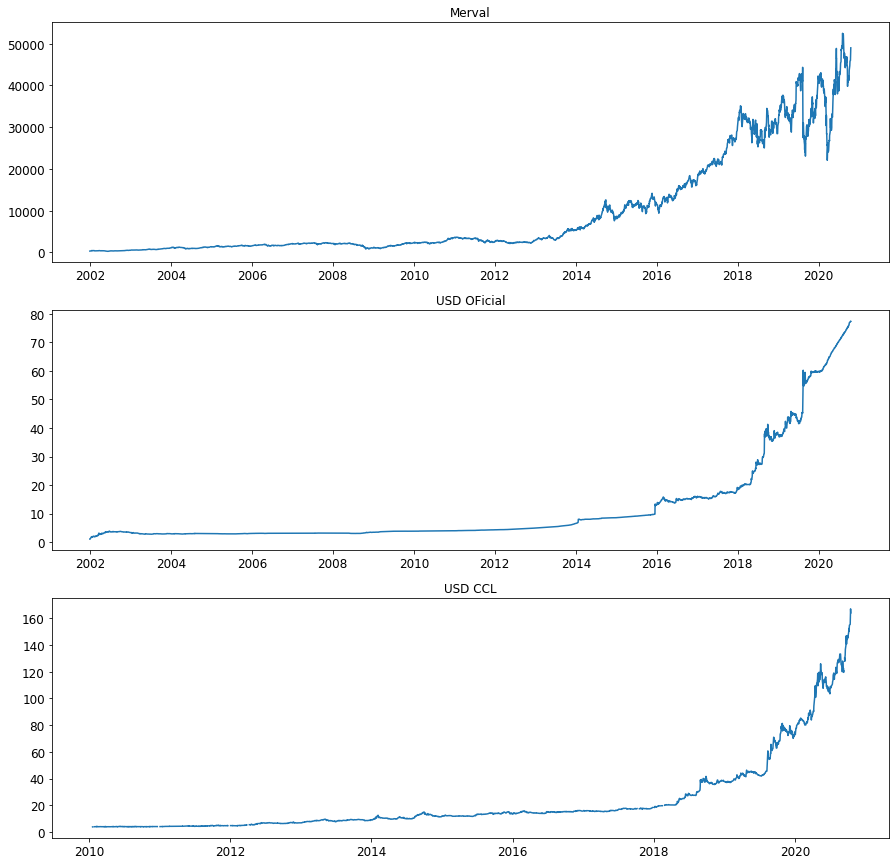

In [19]:
fig, axs = plt.subplots(3, sharex=False, sharey=False,figsize=(15,15))
axs[0].plot(price['.MERV'])
axs[0].title.set_text('Merval')
axs[1].plot(price['ARS='])
axs[1].title.set_text('USD OFicial')
axs[2].plot(price['ARSCONT='])
axs[2].title.set_text('USD CCL')

Cepo Cambiario:

Octubre 2011 - Diciembre 2015


Septiembre 2019 - hoy

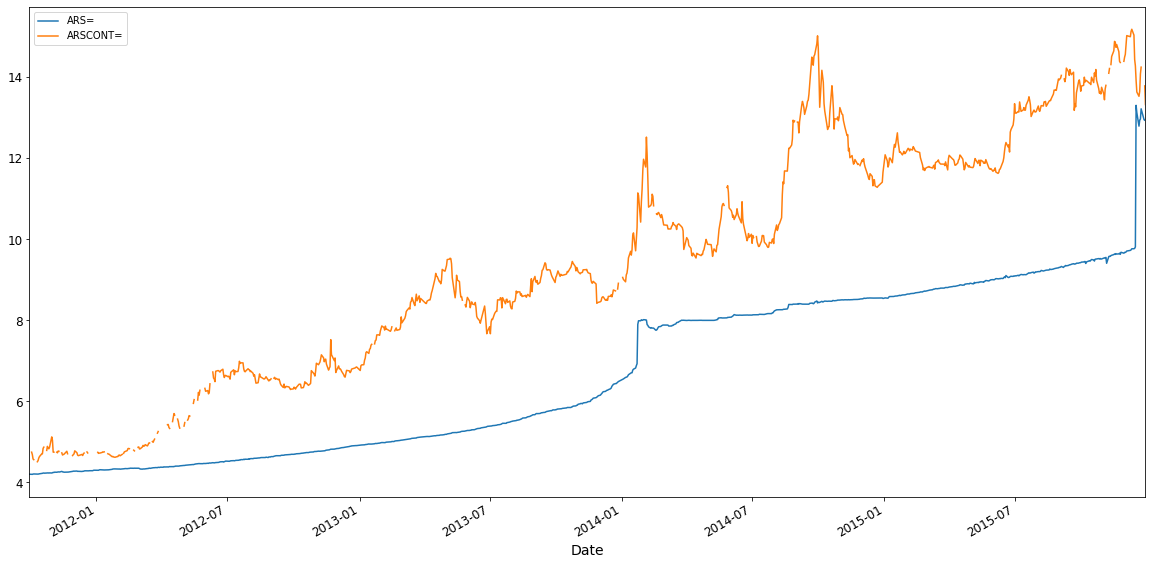

In [20]:
price[['ARS=','ARSCONT=']].loc['2011-09-30':'2016-01-01'].plot(figsize=(20,10))

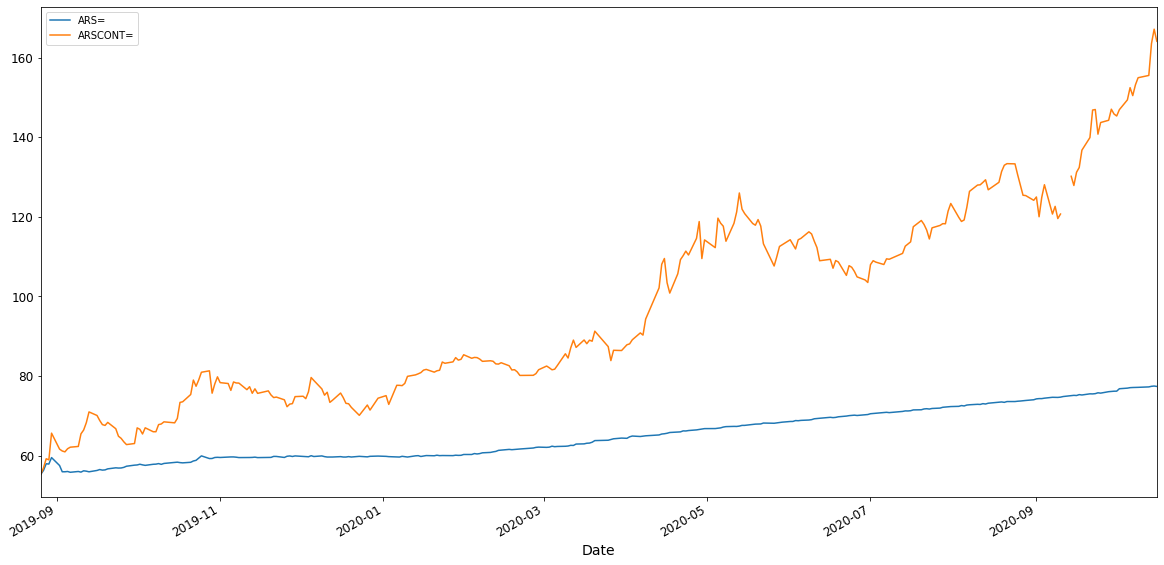

In [21]:
price[['ARS=','ARSCONT=']].loc['2019-08-25':].plot(figsize=(20,10))

Reemplazo en la serie del Dólar oficial aquellos periodos en donde hubo cepo cambiario

In [22]:
price['ARS='].loc['2011-09-30':'2016-01-01'] = price['ARSCONT='].loc['2011-09-30':'2016-01-01']
price['ARS='].loc['2019-08-25':] = price['ARSCONT='].loc['2019-08-25':]

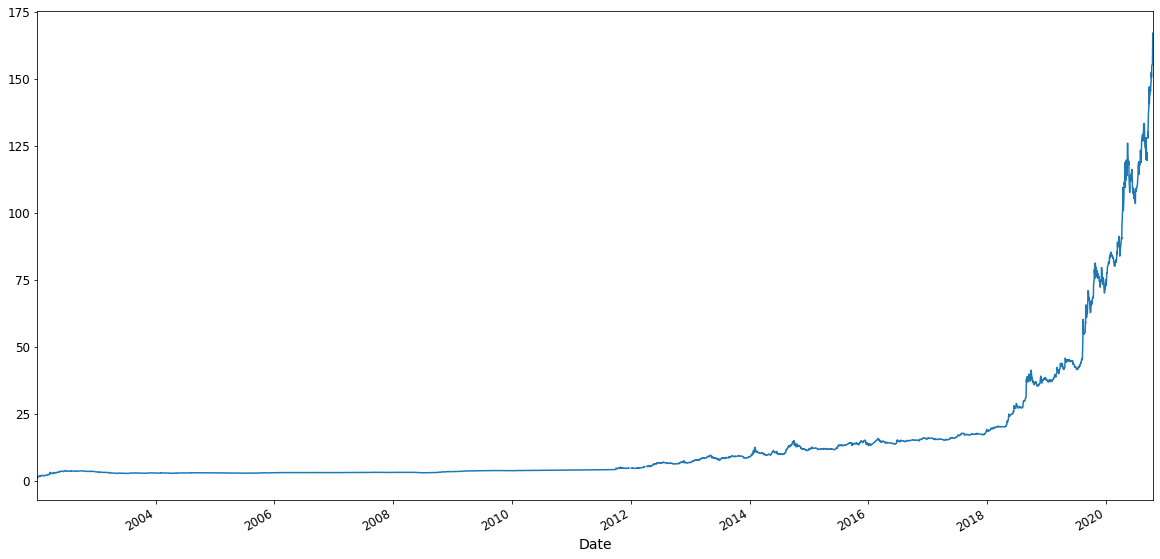

In [23]:
price['ARS='].plot(figsize=(20,10))

Elimino la serie del CCL ya que no la volveré a necesitar y relleno los posibles N/A con el valor del día anterior.

TIP: Los N/A se pueden rellenar con el valor anterior, un promedio entre el siguiente y el anterior, alguna medida de estadística descriptiva como la media o mediana, o algún valor asignado por nosotros (ej: ponerles a todos un cero). Todo depende del problema con el que estemos trabajando.

In [24]:
price.drop(columns='ARSCONT=',inplace=True)
price.fillna(method='ffill',inplace=True)

¿Dólar o Acciones?, la gran pregunta.

- Objetivo: Hacer crecer el capital medido en USD.
- Tarea: En base a la información provista por el mercado decidir si estamos en un escenario en donde conviene estar invertido en acciónes o mantener nuestro capital en Dólar billete.
- Acción: Desarrollar un algoritmo de aprendizaje no supervisado en el que el modelo nos dé su "Best Guess" en base a retornos pasados y volatilidad.

In [25]:
ret = np.log(price/price.shift(1))
ret.dropna(inplace=True)

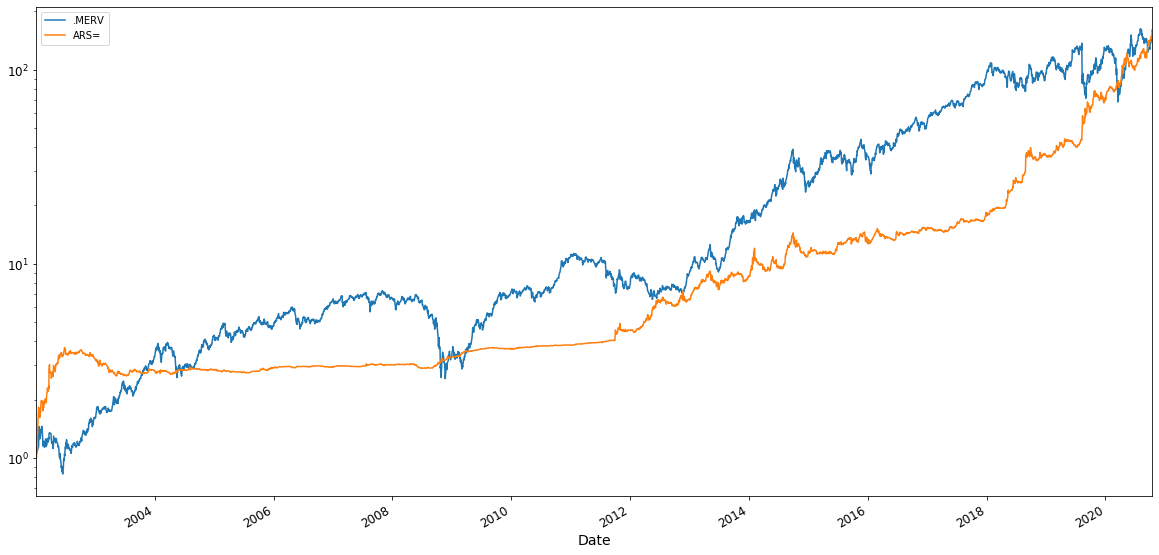

In [26]:
ret.cumsum().apply(np.exp).plot(figsize=(20,10))
plt.yscale('log')

In [27]:
ret

,.MERV,ARS=
Date,,
2002-01-03,0.050923,0.000000
2002-01-04,0.007663,0.000000
2002-01-17,0.078369,0.602633
2002-01-18,0.111200,-0.026668
2002-01-21,0.125961,-0.072861
...,...,...
2020-10-09,0.008188,0.011644
2020-10-13,0.003018,0.003689
2020-10-14,0.027883,0.050261


Cálculo el retorno acumulado de las últimas 22 ruedas (día a día) y la volatilidad del último mes.

In [28]:
ret['MERVm'] = ret['.MERV'].rolling(min_periods=1, window=22).sum()
ret['USDm'] = ret['ARS='].rolling(min_periods=1, window=22).sum()
ret['MERVvol'] = ret['.MERV'].rolling(min_periods=1, window=22).std()*math.sqrt(252)

In [29]:
ret = ret[22:]

In [30]:
ret

,.MERV,ARS=,MERVm,USDm,MERVvol
Date,,,,,
2002-02-18,0.037491,0.000000,0.136770,0.602633,0.953424
2002-02-19,0.012646,0.051293,0.141754,0.653926,0.953663
2002-02-20,-0.016829,0.019803,0.046556,0.071096,0.921385
2002-02-21,-0.046313,-0.034916,-0.110958,0.062848,0.848982
2002-02-22,-0.009064,0.020101,-0.245982,0.155810,0.710684
...,...,...,...,...,...
2020-10-09,0.008188,0.011644,-0.014378,0.259291,0.399951
2020-10-13,0.003018,0.003689,-0.018818,0.253520,0.399152
2020-10-14,0.027883,0.050261,0.031253,0.303781,0.402994


In [31]:
x = ret['MERVm'].values.reshape(-1, 1)
y = ret['USDm'].values.reshape(-1, 1)
z= ret['MERVvol'].values.reshape(-1, 1)

Visualización de las 3 variables:
- Retorno Indice S&P Merval.
- Retorno Dólar.
- Volatilidad Merval.

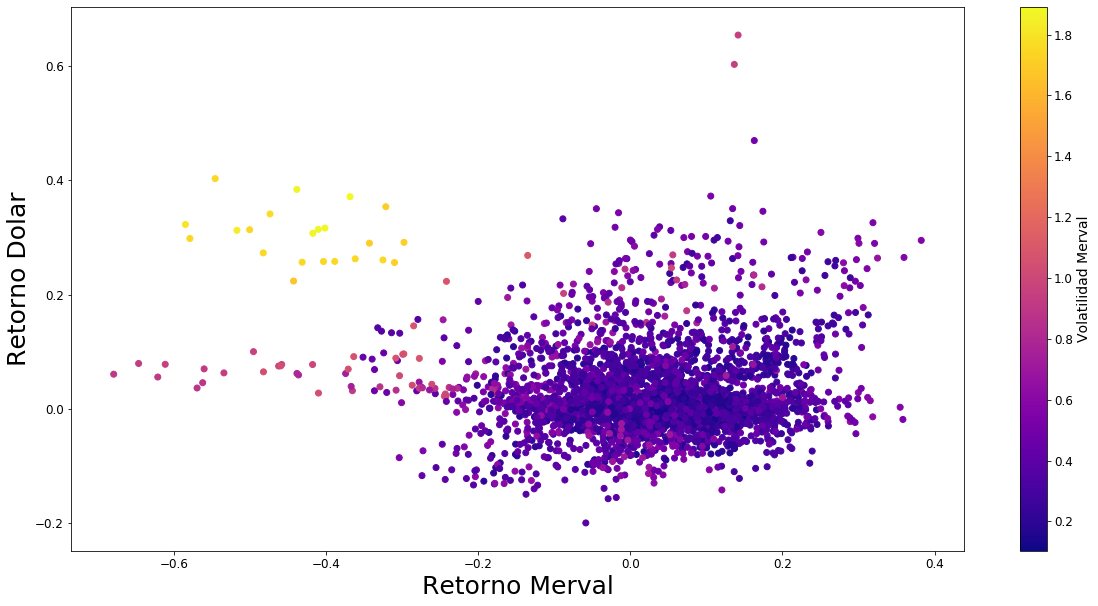

In [32]:
plt.figure(figsize=(20, 10))
plt.scatter(x, y,c=z,cmap='plasma')
plt.colorbar(label='Volatilidad Merval')
plt.xlabel('Retorno Merval', fontsize=25, color='black')
plt.ylabel('Retorno Dolar', fontsize=25, color='black')
plt.show()

In [33]:
inputs = ret[['MERVm','USDm','MERVvol']].to_numpy()

In [34]:
ins = inputs[:int(len(inputs)*0.8)] # Utilizo para entrenar el modelo
ous = inputs[int(len(inputs)*0.8):] # Utilizo para aplicar el modelo y verificar su eficacia

Algoritmo de KMeans

In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(ins) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

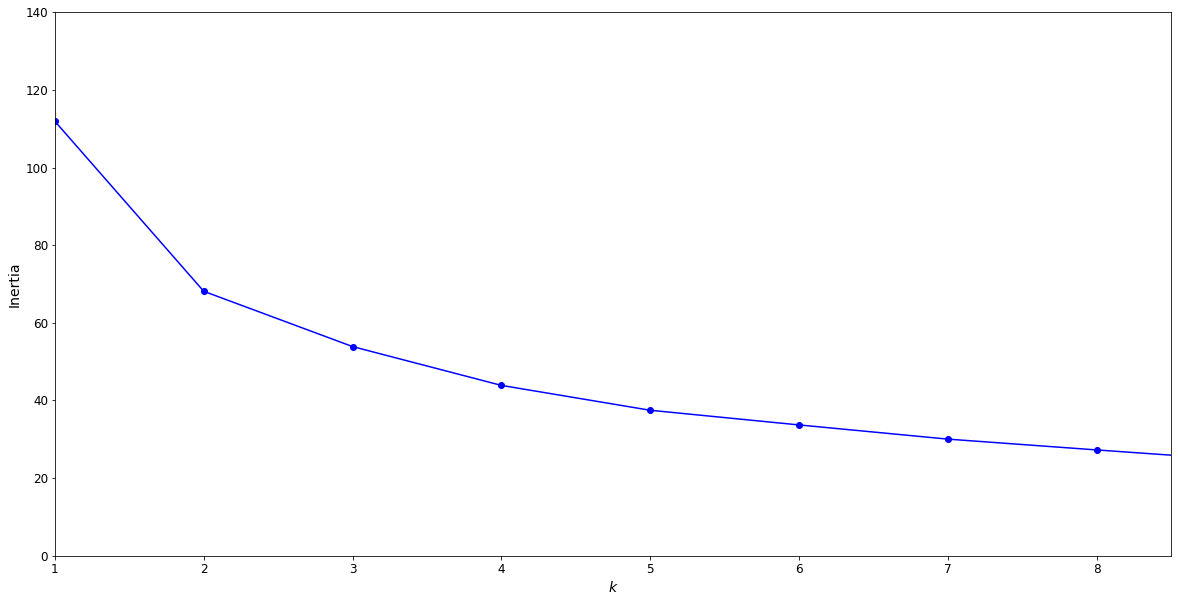

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 140])
plt.show()

In [38]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)

In [39]:
kmeans.fit(ins)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [40]:
kmeans.cluster_centers_

array([[-0.05274418,  0.02134356,  0.47186997],
       [ 0.04774222,  0.01035045,  0.24187675]])

In [41]:
print('K MEANS - CENTROIDES\n')
print('Centroide 0: \n')
print('Retorno Merval Mensual: ' + str(round(kmeans.cluster_centers_[0][0]*100,2)) + '%')
print('Retorno Dolar Mensual: ' + str(round(kmeans.cluster_centers_[0][1]*100,2))+ '%')
print('Volatilidad Realizada Merval: ' + str(round(kmeans.cluster_centers_[0][2]*100,2))+ '%\n')
print('Centroide 1: \n')
print('Retorno Merval Mensual: ' + str(round(kmeans.cluster_centers_[1][0]*100,2)) + '%')
print('Retorno Dolar Mensual: ' + str(round(kmeans.cluster_centers_[1][1]*100,2))+ '%')
print('Volatilidad Realizada Merval: ' + str(round(kmeans.cluster_centers_[1][2]*100,2))+ '%\n')

K MEANS - CENTROIDES

Centroide 0: 

Retorno Merval Mensual: -5.27%
Retorno Dolar Mensual: 2.13%
Volatilidad Realizada Merval: 47.19%

Centroide 1: 

Retorno Merval Mensual: 4.77%
Retorno Dolar Mensual: 1.04%
Volatilidad Realizada Merval: 24.19%



Algoritmo de Mixturas Gaussianas.

In [42]:
from sklearn.mixture import GaussianMixture

In [43]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(ins)
             for k in range(1, 11)]

In [44]:
bics = [model.bic(ins) for model in gms_per_k]
aics = [model.aic(ins) for model in gms_per_k]

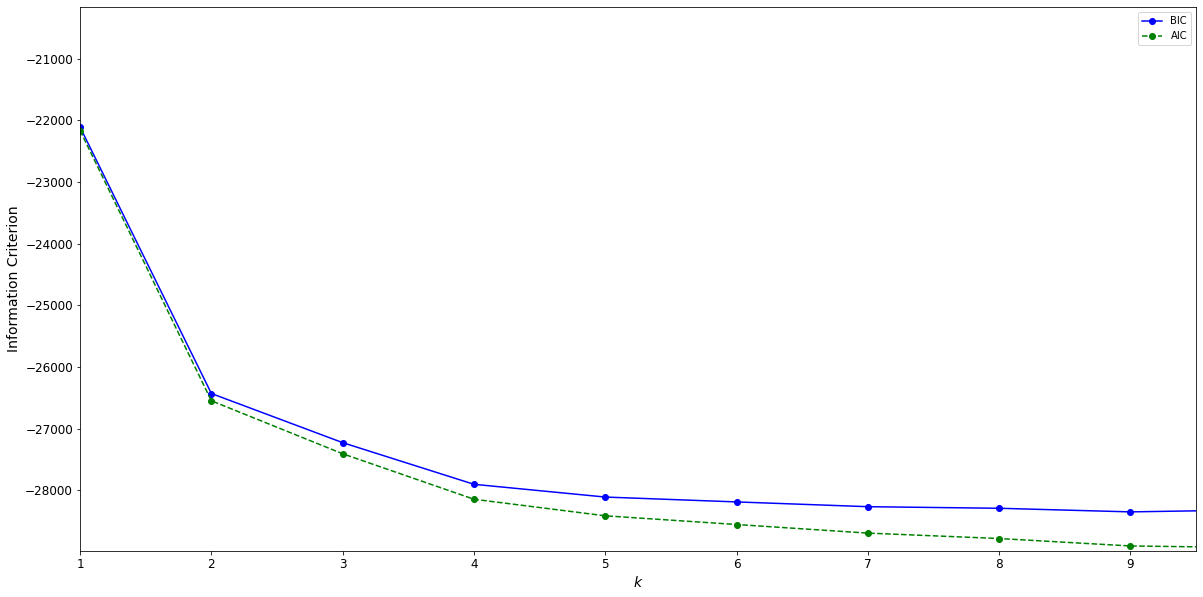

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 2000])
plt.legend()
plt.show()

In [46]:
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(ins)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [47]:
gm.means_

array([[0.01623921, 0.02874879, 0.37498609],
       [0.02700225, 0.00116329, 0.24260448]])

In [49]:
print('Gaussian Mixtures - CENTROIDES\n')
print('Centroide 0: \n')
print('Retorno Merval Mensual: ' + str(round(gm.means_[0][0]*100,2)) + '%')
print('Retorno Dolar Mensual: ' + str(round(gm.means_[0][1]*100,2))+ '%')
print('Volatilidad Realizada Merval: ' + str(round(gm.means_[0][2]*100,2))+ '%\n')
print('Centroide 1: \n')
print('Retorno Merval Mensual: ' + str(round(gm.means_[1][0]*100,2)) + '%')
print('Retorno Dolar Mensual: ' + str(round(gm.means_[1][1]*100,2))+ '%')
print('Volatilidad Realizada Merval: ' + str(round(gm.means_[1][2]*100,2))+ '%\n')

Gaussian Mixtures - CENTROIDES

Centroide 0: 

Retorno Merval Mensual: 1.62%
Retorno Dolar Mensual: 2.87%
Volatilidad Realizada Merval: 37.5%

Centroide 1: 

Retorno Merval Mensual: 2.7%
Retorno Dolar Mensual: 0.12%
Volatilidad Realizada Merval: 24.26%



In [50]:
ret[['MERVm','USDm','MERVvol']]

,MERVm,USDm,MERVvol
Date,,,
2002-02-18,0.136770,0.602633,0.953424
2002-02-19,0.141754,0.653926,0.953663
2002-02-20,0.046556,0.071096,0.921385
2002-02-21,-0.110958,0.062848,0.848982
2002-02-22,-0.245982,0.155810,0.710684
...,...,...,...
2020-10-09,-0.014378,0.259291,0.399951
2020-10-13,-0.018818,0.253520,0.399152
2020-10-14,0.031253,0.303781,0.402994


Backtesting - KMeans

In [51]:
df = pd.DataFrame({'merv':0.0,'usd':0.0},index = ret[1000:].index)

In [52]:
df

,merv,usd
Date,,
2006-02-21,0.0,0.0
2006-02-22,0.0,0.0
2006-02-23,0.0,0.0
2006-02-24,0.0,0.0
2006-02-27,0.0,0.0
...,...,...
2020-10-09,0.0,0.0
2020-10-13,0.0,0.0
2020-10-14,0.0,0.0


In [53]:
for i in range(0,len(inputs[1000:]-1)):
    model = KMeans(n_clusters=2 ,n_init=42)
    model.fit(inputs[:1000+i])
    
    if model.predict(inputs[1000:1001+i])[i] == 0:
        probabilidad = np.array([[1, 0]])    
    else:
        probabilidad = np.array([[0, 1]])
    
    if model.cluster_centers_[0][0] > model.cluster_centers_[1][0]: #Centroide 0 es Comprar Merval, Centroide 1 es Comprar USD 
        df.iat[i,0] = probabilidad[0][0]            
        df.iat[i,1] = probabilidad[0][1] 
            
    else: #Centroide 0 es Comprar USD, Centroide 1 es Comprar Merval 
        df.iat[i,0] = probabilidad[0][1]            
        df.iat[i,1] = probabilidad[0][0] 

In [54]:
df

,merv,usd
Date,,
2006-02-21,1.0,0.0
2006-02-22,1.0,0.0
2006-02-23,1.0,0.0
2006-02-24,1.0,0.0
2006-02-27,1.0,0.0
...,...,...
2020-10-09,0.0,1.0
2020-10-13,0.0,1.0
2020-10-14,0.0,1.0


In [55]:
ret[['.MERV','ARS=']].loc['2006-02-21':'2020-10-16']

,.MERV,ARS=
Date,,
2006-02-21,0.012959,0.001630
2006-02-22,-0.008866,0.000000
2006-02-23,-0.008175,0.000814
2006-02-24,0.007277,0.000000
2006-02-27,0.005527,0.000000
...,...,...
2020-10-09,0.008188,0.011644
2020-10-13,0.003018,0.003689
2020-10-14,0.027883,0.050261


In [56]:
ret[['.MERV','ARS=']].loc['2006-02-21':'2020-10-16'].shift(-1)

,.MERV,ARS=
Date,,
2006-02-21,-0.008866,0.000000
2006-02-22,-0.008175,0.000814
2006-02-23,0.007277,0.000000
2006-02-24,0.005527,0.000000
2006-02-27,-0.012851,-0.000814
...,...,...
2020-10-09,0.003018,0.003689
2020-10-13,0.027883,0.050261
2020-10-14,0.019763,0.021801


In [58]:
ret_strat = ret[['.MERV','ARS=']].loc['2006-02-21':'2020-10-16'].shift(-1)
ret_strat.dropna(inplace=True)

In [61]:
ret_strat

,.MERV,ARS=
Date,,
2006-02-21,-0.008866,0.000000
2006-02-22,-0.008175,0.000814
2006-02-23,0.007277,0.000000
2006-02-24,0.005527,0.000000
2006-02-27,-0.012851,-0.000814
...,...,...
2020-10-08,0.008188,0.011644
2020-10-09,0.003018,0.003689
2020-10-13,0.027883,0.050261


Calculo el resultado de la estrategia y creo el benchmark (60% merval/ 40% usd)

In [62]:
strat = df['merv'] * ret_strat['.MERV'] + df['usd'] * ret_strat['ARS=']
benchmark = 0.6 * ret_strat['.MERV'] + 0.4 * ret_strat['ARS=']

Grafico ambos resultados

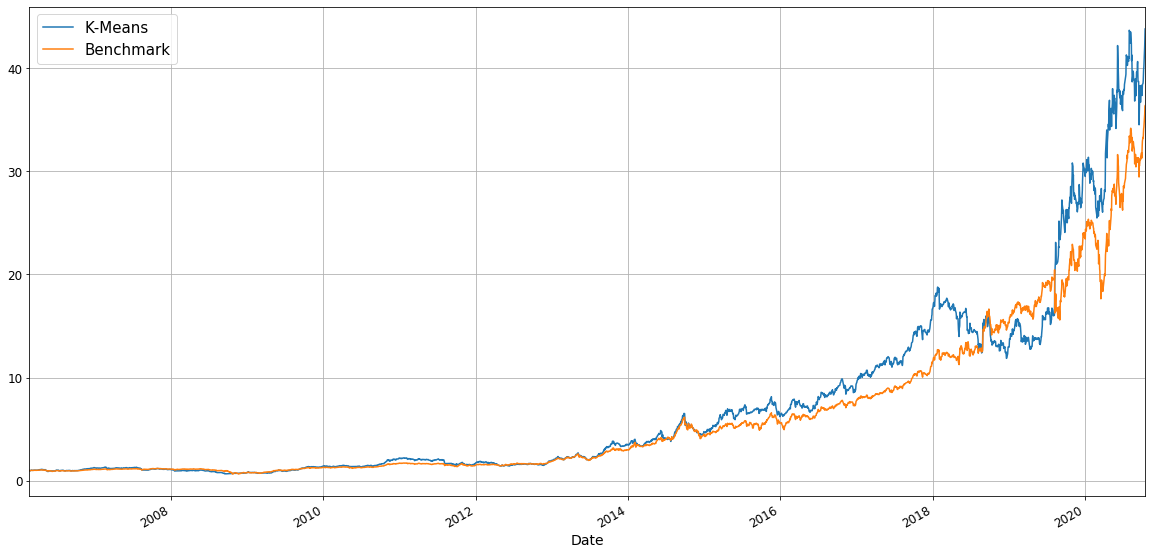

In [64]:
strat.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "K-Means").grid
benchmark.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Benchmark").grid
plt.legend(loc=2, prop={'size': 15})
plt.grid()

Backtesting - Mixturas Gaussianas

In [65]:
df_gm = pd.DataFrame({'merv':0.0,'usd':0.0},index = ret[1000:].index)

In [66]:
for i in range(0,len(inputs[1000:]-1)):
    model = GaussianMixture(n_components=2, n_init=10, random_state=42)
    model.fit(inputs[:1000+i])
    probabilidad = model.predict_proba(inputs[1000:1001+i])
    
    if model.means_[0][0] > model.means_[1][0]:
        df_gm.iat[i,0] = probabilidad[i][0]            
        df_gm.iat[i,1] = probabilidad[i][1]   
            
    else:        
        df_gm.iat[i,0] = probabilidad[i][1]            
        df_gm.iat[i,1] = probabilidad[i][0] 

In [67]:
df_gm

,merv,usd
Date,,
2006-02-21,9.979250e-01,0.002075
2006-02-22,9.977965e-01,0.002203
2006-02-23,9.975958e-01,0.002404
2006-02-24,9.977086e-01,0.002291
2006-02-27,9.976480e-01,0.002352
...,...,...
2020-10-09,1.531509e-38,1.000000
2020-10-13,9.074409e-37,1.000000
2020-10-14,6.403023e-54,1.000000


In [68]:
strat2 = df_gm['merv'] * ret_strat['.MERV'] + df_gm['usd'] * ret_strat['ARS=']

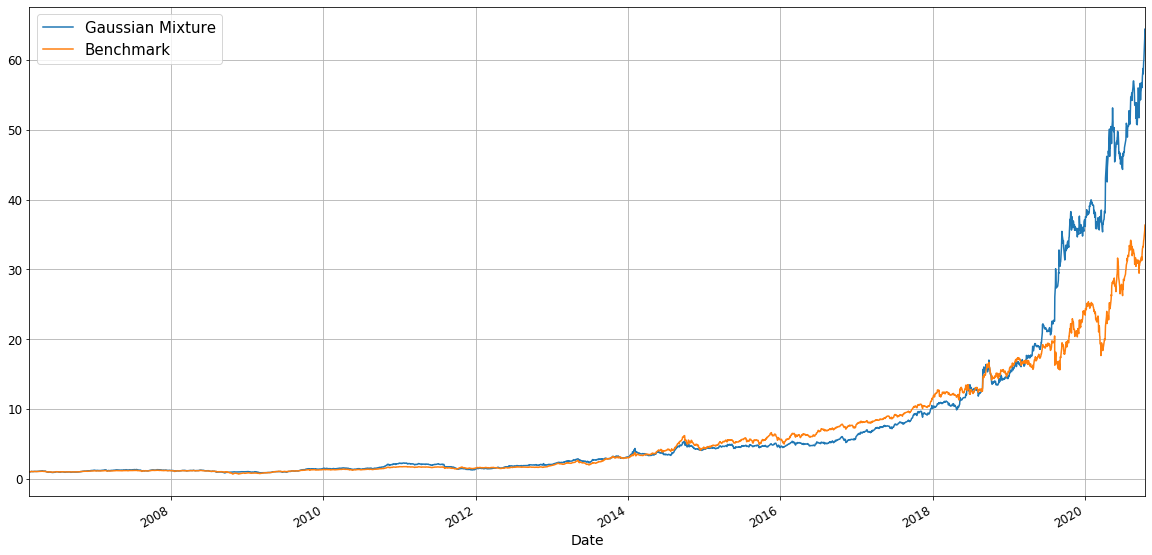

In [69]:
strat2.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Gaussian Mixture").grid
benchmark.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Benchmark").grid
plt.legend(loc=2, prop={'size': 15})
plt.grid()

Backtesting - Ensemble Learning

In [70]:
strat3 = (strat+strat2)/2

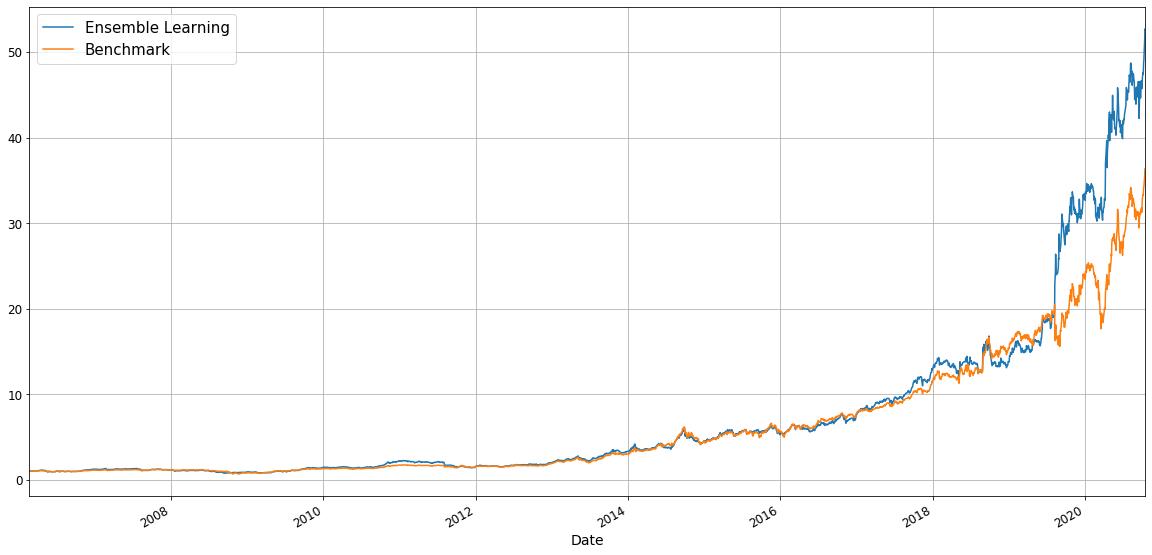

In [71]:
strat3.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Ensemble Learning").grid
benchmark.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Benchmark").grid
plt.legend(loc=2, prop={'size': 15})
plt.grid()

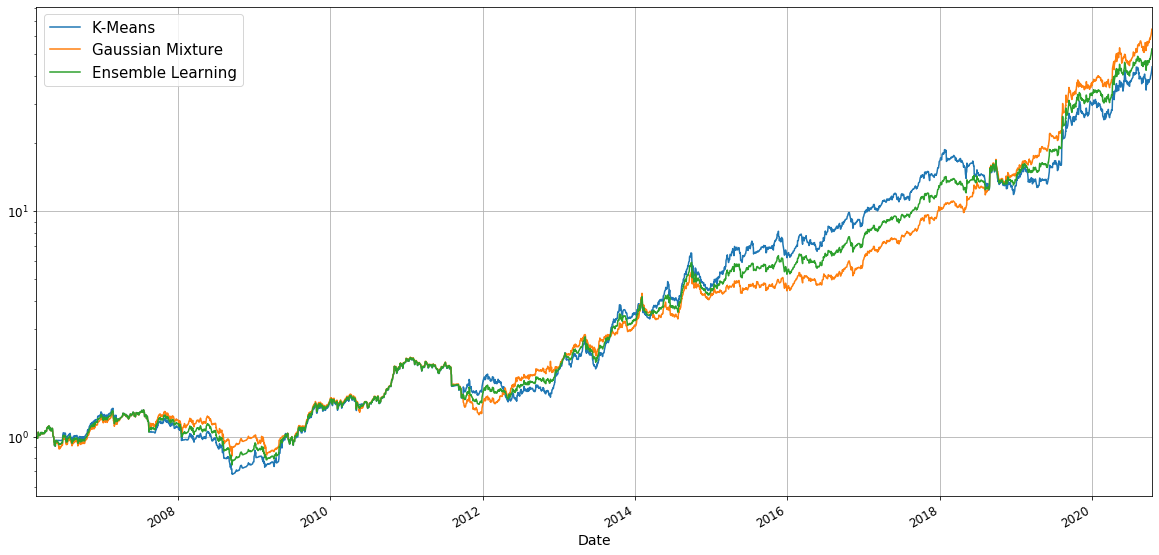

In [72]:
strat.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "K-Means").grid
strat2.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Gaussian Mixture").grid
strat3.loc[:].cumsum().apply(np.exp).plot(figsize=(20,10), label= "Ensemble Learning").grid
plt.legend(loc=2, prop={'size': 15})
plt.yscale('log')
plt.grid()

In [73]:
strat.dropna(inplace=True)
strat2.dropna(inplace=True)
strat3.dropna(inplace=True)
benchmark.dropna(inplace=True)

In [74]:
a = np.argmax(np.maximum.accumulate(strat.cumsum()) - strat.cumsum()) #K-Means
b = np.argmax(strat.cumsum()[:a])
c = np.argmax(np.maximum.accumulate(strat2.cumsum()) - strat2.cumsum()) #Gaussian Mixtures
d = np.argmax(strat2.cumsum()[:c])
e = np.argmax(np.maximum.accumulate(strat3.cumsum()) - strat3.cumsum()) #Ensemble Learning
f = np.argmax(strat3.cumsum()[:e])
i = np.argmax(np.maximum.accumulate(benchmark.cumsum()) - benchmark.cumsum())
j = np.argmax(benchmark.cumsum()[:i])

print('Sharpe K-Means: ' + str((strat.mean()*252)/(strat.std()*(252**0.5))))
print('Sharpe Gaussian Mixture: ' + str((strat2.mean()*252)/(strat2.std()*(252**0.5))))
print('Sharpe Ensemble Learning: ' + str((strat3.mean()*252)/(strat3.std()*(252**0.5))))
print('Sharpe Benchmark: ' + str((benchmark.mean()*252)/(benchmark.std()*(252**0.5))))
print()
print('Retorno Promedio Anual K-Means: ' + str((((1+((strat.cumsum().apply(np.exp)[-1] / 1) - 1))**(1/14)) - 1)*100))
print('Retorno Promedio Anual Gaussian Mixture: ' + str((((1+((strat2.cumsum().apply(np.exp)[-1] / 1) - 1))**(1/14)) - 1)*100))
print('Retorno Promedio Anual Ensemble Learning: ' + str((((1+((strat3.cumsum().apply(np.exp)[-1] / 1) - 1))**(1/14)) - 1)*100))
print('Retorno Promedio Benchmark: ' + str((((1+((benchmark.cumsum().apply(np.exp)[-1] / 1) - 1))**(1/14)) - 1)*100))
print()
print('Worst Drawdown K-Means: ' + str(((strat.cumsum().apply(np.exp)[a] / strat.cumsum().apply(np.exp)[b])-1)*100) + ' desde ' + str(b) + ' hasta ' + str(a))
print('Worst Drawdown Gaussian Mixture: ' + str(((strat2.cumsum().apply(np.exp)[c] / strat2.cumsum().apply(np.exp)[d])-1)*100) + ' desde ' + str(d) + ' hasta ' + str(c))
print('Worst Drawdown Ensemble Learning: ' + str(((strat3.cumsum().apply(np.exp)[e] / strat3.cumsum().apply(np.exp)[f])-1)*100) + ' desde ' + str(f) + ' hasta ' + str(e))
print('Worst Drawdown Benchmark: ' + str(((benchmark.cumsum().apply(np.exp)[i] / benchmark.cumsum().apply(np.exp)[j])-1)*100) + ' desde ' + str(j) + ' hasta ' + str(i))
print()
print('Standar Deviation K-Means: ' + str(strat.std()*(252**0.5)*100))
print('Standar Deviation Gaussian Mixture: ' + str(strat2.std()*(252**0.5)*100))
print('Standar Deviation Ensemble Learning: ' + str(strat3.std()*(252**0.5)*100))
print('Standar Deviation Benchmark: ' + str(benchmark.std()*(252**0.5)*100))
print()
print('Mayor Caida Diaria K-Means: ' + str(strat.min()))
print('Mayor Caida Diaria Gaussian Mixture: ' + str(strat2.min()))
print('Mayor Caida Diaria Ensemble Learning: ' + str(strat3.min()))
print('Mayor Caida Diaria Benchmark: ' + str(benchmark.min()))
print()
print('Retorno Acumulado K-Means: ' + str(((strat.cumsum().apply(np.exp)[-1] / 1) - 1) *100))
print('Retorno Acumulado Gaussian Mixture: ' + str(((strat2.cumsum().apply(np.exp)[-1] / 1) - 1) *100))
print('Retorno Acumulado Ensemble Learning: ' + str(((strat3.cumsum().apply(np.exp)[-1] / 1) - 1) *100))
print('Retorno Acumulado Benchmark: ' + str(((benchmark.cumsum().apply(np.exp)[-1] / 1) - 1) *100))

Sharpe K-Means: 0.9294982154271199
Sharpe Gaussian Mixture: 1.1260629599652752
Sharpe Ensemble Learning: 1.1044951810016583
Sharpe Benchmark: 1.0659789495424812

Retorno Promedio Anual K-Means: 30.99017144758367
Retorno Promedio Anual Gaussian Mixture: 34.47991239338195
Retorno Promedio Anual Ensemble Learning: 32.72357281457252
Retorno Promedio Benchmark: 29.261172279408786

Worst Drawdown K-Means: -48.949793101206104 desde 2007-02-23 00:00:00 hasta 2008-09-19 00:00:00
Worst Drawdown Gaussian Mixture: -44.37850769136573 desde 2011-01-19 00:00:00 hasta 2011-12-14 00:00:00
Worst Drawdown Ensemble Learning: -43.043464221802665 desde 2007-07-20 00:00:00 hasta 2008-09-16 00:00:00
Worst Drawdown Benchmark: -45.21781225949643 desde 2007-10-30 00:00:00 hasta 2008-11-20 00:00:00

Standar Deviation K-Means: 28.565074526095447
Standar Deviation Gaussian Mixture: 25.875279218200152
Standar Deviation Ensemble Learning: 25.209878802467696
Standar Deviation Benchmark: 23.681806078773736

Mayor Caida

C:\Users\U6042553\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
